Curtis Sera <br>
v2.3 <br>
2020-11-09

# Protrusion base: before and after fusion

## Introduction
This is a simple comparison of the bending energies for a fusion event occuring in/at the <i>Bt</i> protrusion base.  Starting with the protrusion set-up shown on the left and ending with the geometry shown on the right:
<img src="Imgs/base_fusion.jpg" width=600 /><br>

We will again split the protrusion into three idealized sections: toroidal base, cylindrical body, hemispherical cap.  We will further make the simplifying assumptions that only the toroidal base has changed geometry (perhaps this is very shortly after fusion) and that any excess membrane has been able to flow into a stress-free bulk, save for the residual pore rim where the protrusion was "cut".  Thus, our expression for the change in bending energy is simply:

$\Delta G = (G_{pore} + G_{base rim} ) - G_{toroidal base}$

That is, within this model we don't need to pay attention to anything other than the base and what it turns into.

The relevant comparisons are for a fusion without a protrusion, fusion in the body, and fusion in the cap.  To make complete comparisons, it would be ideal to fully calculate pore + residual membrane energies for each situation.  However, the pore energy is not needed to make the base fusion vs protrusion-less fusion comparison since the pore energy is the same in those cases once the protrusion has been cut off.

## Set-up
To get started, let's first set our key system properties.  We'll be using the same variable names as in FusionPoreExpanG.ipynb.  The scheme for the protrusion base is shown on the left, and the scheme for a the protrusion base's post-fusion rim is shown on the right (adapted from the fusion pore scheme).

<img src="Imgs/tor_base_xsection.jpg" width=550 />   <img src="Imgs/base_rim.jpg" width=550 />

Note that the diagram for the base rim is not to scale.

We will make the rim toroidal (the bottom of a donut), and $r_{t,rim}$ will be the intermembrane distance.  Two intermembrane distance will be 25 nm which is what I measured from 2019-08-05's infected-0040.tif and which is ~consistent with the known ER intermembrane distance of 30 nm.

In [5]:
import numpy as np
import plotly.graph_objs as go

# Membrane properties
Kb = 15         # kT

# Pre-fusion properties
R0 = 400        # nm
Rt = 200        # nm

# Post-fusion properties
rim_rt = np.linspace(2,55,num=150)    # nm
    # the intermembrane distance of the residual protrusion
    # (ie toroidal rim's tube radius)

def helfrichStress(k1,k2,Kb):
    '''
    Helfrich bending *stress*
    
    Args:
        k1 (float): Principal curvature 1; 1/nm
        k2 (float): Principal curvature 2; 1/nm
        Kb (float): Helfrich bending constant for membrane; kT/nm^2
    Returns:
        float: The Helfrich bending *stress* (ie energy for an infinitesimal dA) 
    '''
    return 0.5*Kb*(k1+k2)**2 # Note units = energy/unit area = kT/nm^2

def torusCircCurv(R,r,u):
    '''
    Curvature (reciprocal of radius of curvature) on a torus at a point defined by the angle u due 
    to connecting the tube ends.  The "circumferential curvature".
    
    Args:
        R (float): distance from torus center to inner wall; nm
        r (float): torus tube radius; nm
        u (float): angle giving location on the relevant slice of tube where 0 points transversely *out*; radians
    Returns:
        float: Circumferential curvature; 1/nm
    '''
    return (np.cos(u)) / (R + r + r*np.cos(u));

def GToroidalPore(R,r,Kb):
    '''
    Bending energy for a toroidal pore *with no spontaneous curvature*.
    
    Args:
        R (float): distance from torus center to inner wall; nm
        r (float): torus tube radius; nm
        Kb (float): Helfrich bending constant for membrane; kT/nm^2
    Returns:
        float: Pore bending energy; kT
    '''
    return Kb*np.pi*2* ( np.arctan(np.sqrt((r+2*R)/r)) * (2*(r+R)**2)/(R*np.sqrt(r**2+2*R*r)) - 4 );

## Computation: pre-fusion base

Our torus curvature is defined in terms of an angle $u$ which is oriented outward.  In otherwords, the pre-fusion base curvature must be rewritten as $u_{base} = \pi - \beta$ in our coordinate scheme.  We can solve for this in terms of $z$ (the axis serving as the center of rotational symmetry) and the base torus tube radius $Rt$ to get the expression: <br>
$u_{base} = \pi - arcsin \left(\frac{R_t - z}{R_t} \right)$
where $z=0$ where the protrusion first curves away from the main cell membrane.  See 2020-07-24 notes in lab notebook for more details.

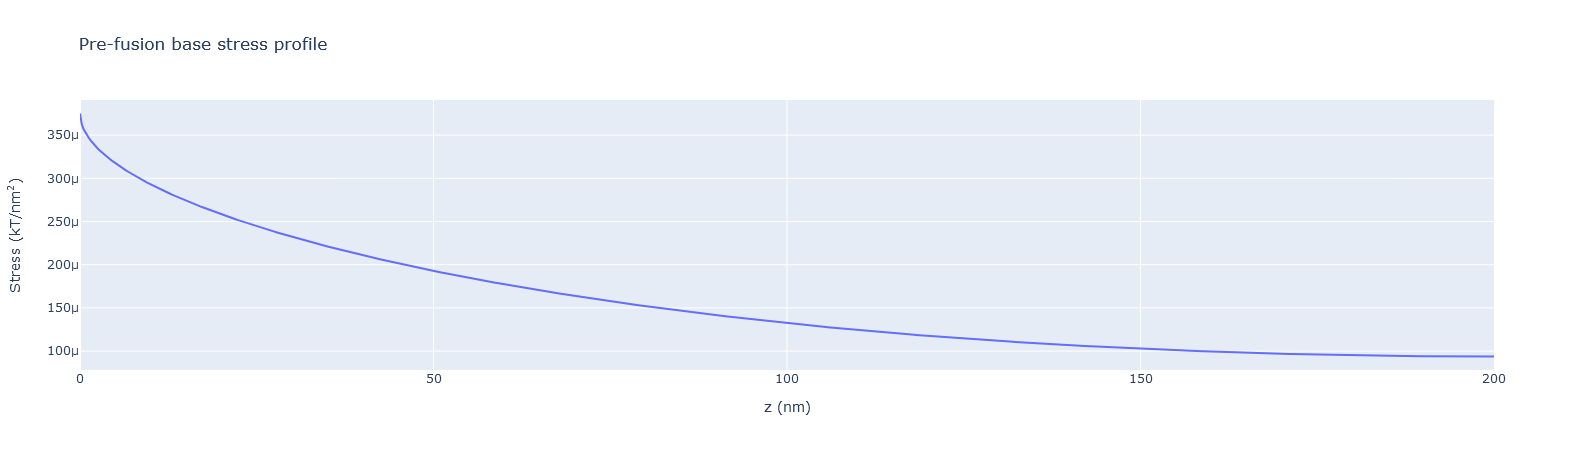

Total Gb of pre-fusion base =  117.65287461415454  kT


In [6]:
zBase = np.linspace(0,Rt,num=Rt*4 + 1) #Will be using this to take a left Riemann sum
#print(zBase)
uBase = np.pi - np.arcsin((Rt-zBase)/Rt) # in radians
#print(uBase)

kBaseCirc = np.zeros(zBase.size)
stressBase = np.zeros(zBase.size)
GRingPre = np.zeros(zBase.size-1)
GPre = 0

#First calculate the curvatures
for k in range(0,zBase.size):
    kBaseCirc[k] = torusCircCurv(R0,Rt,uBase[k])
#print("kBaseCirc = ",kBaseCirc)

#Next calculate the per unit area stress profile
for s in range(0,zBase.size):
    stressBase[s] = helfrichStress(kBaseCirc[s],1/Rt,Kb*2) # Kb*2 since 2x membrane protrusion
#print(stressBase)

#Now find the energy of the discrete zBase rings via left Riemann sum
R1 = R0 + Rt-np.sqrt(1-((Rt-zBase)/Rt)**2)
     #Dist from z axis to membrane at given z (using trig a identity)
#print(R1)
for ring in range(0,GRingPre.size):
    #Stress per ring by finding cylindrical wall area * ring stress
    GRingPre[ring] = np.pi * 2*R1[ring] * (zBase[1]-zBase[0]) * stressBase[ring]

GPre = np.sum(GRingPre)

preStress = go.Figure()
preStress.add_trace(go.Scatter(x=zBase, y=stressBase, mode='lines'))
preStress.update_layout(title="Pre-fusion base stress profile",
                        xaxis_title="z (nm)", yaxis_title="Stress (kT/nm<sup>2</sup>)")
preStress.show()

print("Total Gb of pre-fusion base = ",GPre," kT")

Validation of my "simulation parameter" validation:
- Dividing the z axis in to 1+Rt*n steps.  Choosing n=4 appears to be quite sufficient.  The final figure for GPre changes only slightly for n=2-->4, and there is no meaningful difference from n=4-->1000
    - Pass!

## Computation: post-fusion base rim via z-axis Riemann sum in cylindrical coordinates + toroidal pore in bulk

*Caution: It is tempting to apply Christoph and Rob's (2011 paper) solution for conical pores to this situation.  However, we cannot.  Their conical set-up requires an imagined vertex that the membrane would converge to.  On the other hand, my cylindrical set-up is at a 90 degree rotation (where 0 is a perfectly flat membrane) and would only have such a vertex if the tube radius was infinitely thin.  We must therefore calculate this via direct application of toroidal geometry.*

This method poses the problem that each location on the z axis corresponds to 2 angles (except at the end).  However, we can use the same trigonometric method that we used in the previous section:

$u_{rim} = \left\{ \pi - arcsin \left(\frac{R_t - z}{R_t} \right) \cup arcsin \left(\frac{R_t - z}{R_t} \right) \right\}$

Note that this will double-count $u_{rim} = \pi/2$, but that shouldn't be a huge problem since its contribution will be small compared to the whole.

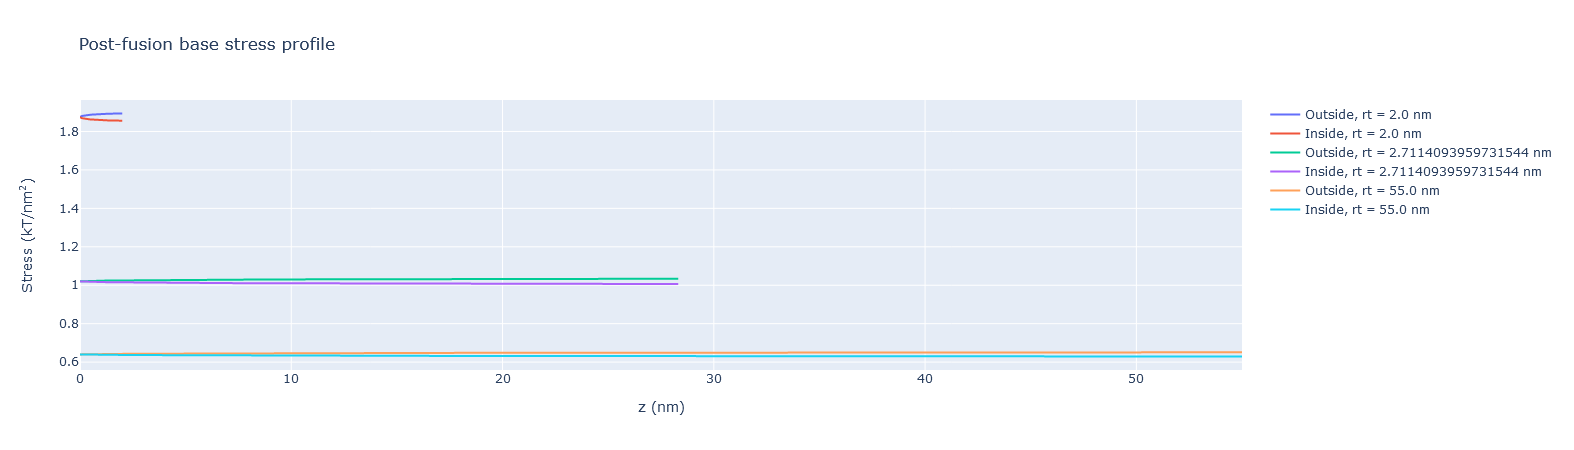

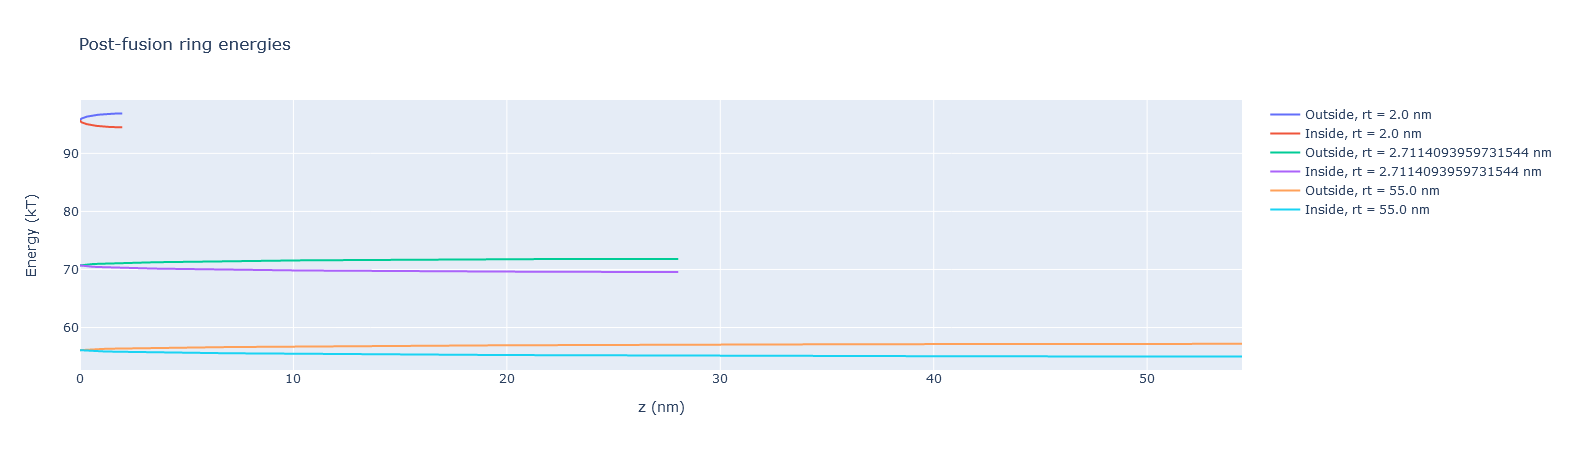

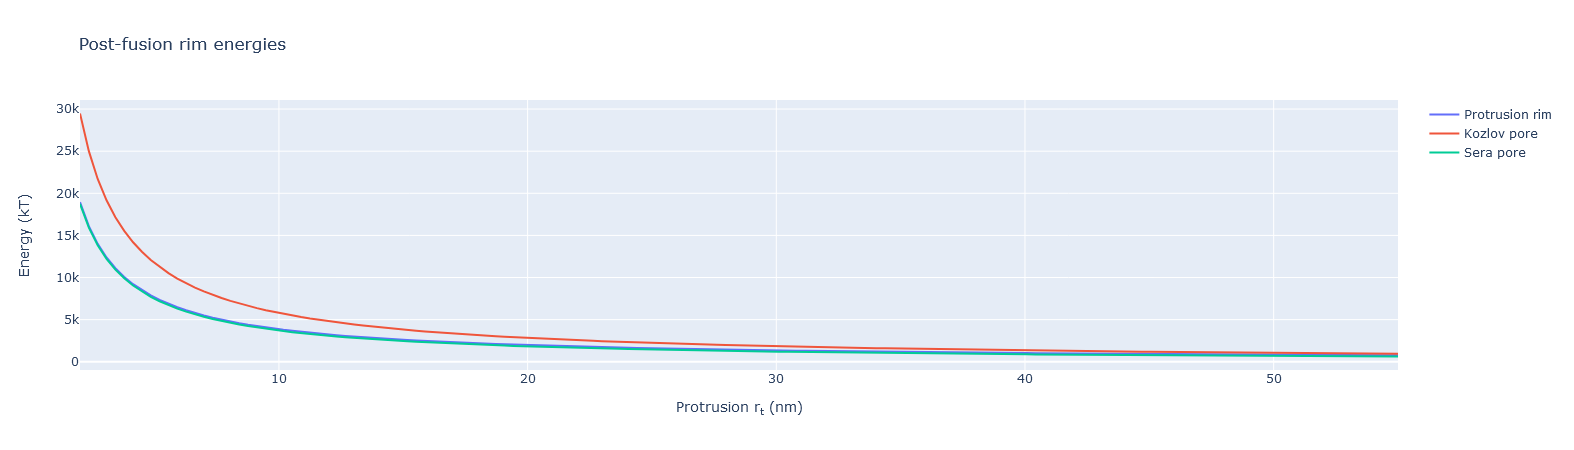

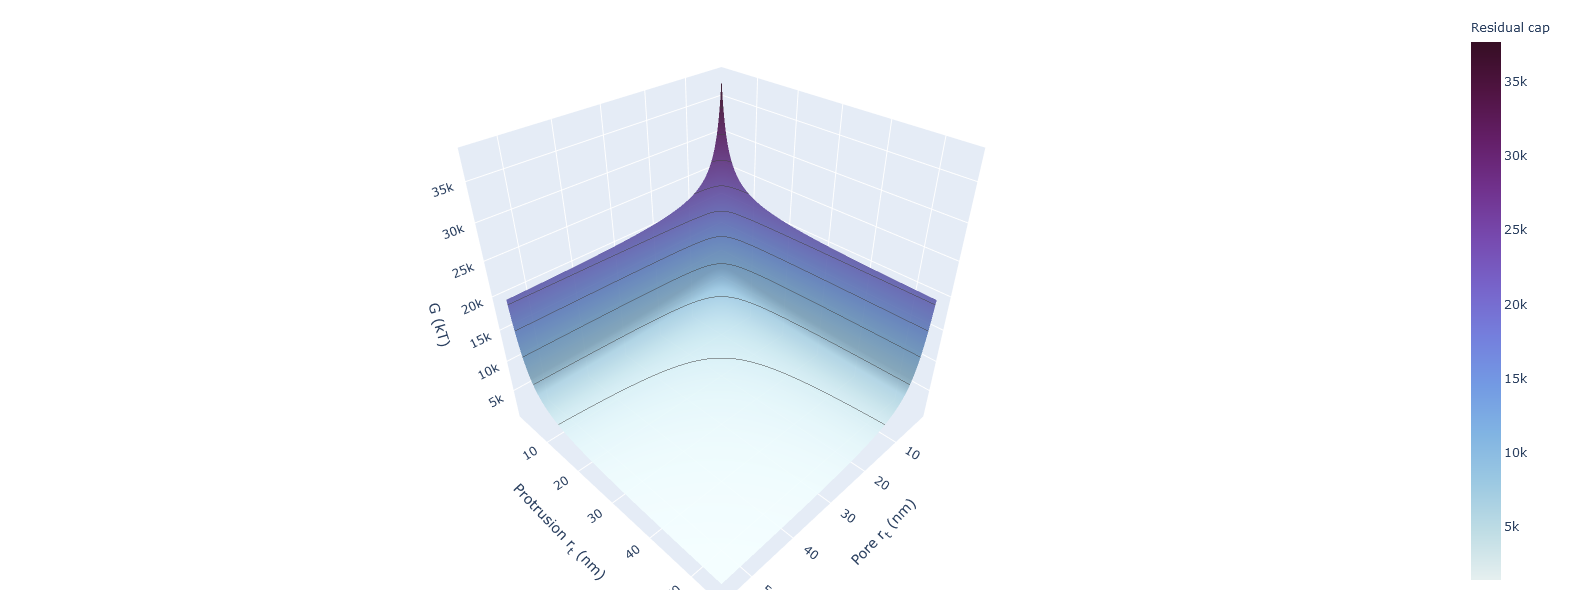

In [7]:
zSteps = 100
zRim = [np.linspace(0,rim_rt[0],num=zSteps)] # nm
for rt in range(1,rim_rt.size):
    zRim.append(np.linspace(0,rim_rt[rt],num=zSteps))

uRim = np.zeros((rim_rt.size,zSteps,2)) # radians
    # rim tube angle for each rim_rt as a function of z where uRim1 = 0 is 
    # defined as pointing outward on the bisecting transverse plane
    # 3rd dimension to acct for the fact that each z has a u for the inner 
    # surface and a u for the outer surface
    # Dims: rt value, place along z axis, whether inside (0) or outside (1)

kRim = np.zeros((rim_rt.size,zSteps,2)) # 1/nm; curv for each angle u on rim
    # curvature for each rim_rt value at each zRim along the rim surface
stressRim = np.zeros((rim_rt.size,zSteps,2)) # kT/nm^2; stress at each point
GRingPost = np.zeros((rim_rt.size,zSteps-1,2)) # kT; G_b of each ring
    # zRim.size-1 since Reimann summing reduces num of elements by 1
GProtrPost = np.zeros(rim_rt.size)

uPore = np.zeros((rim_rt.size,zSteps)) # radians
kPore = np.zeros((rim_rt.size,zSteps)) # 1/nm; curv for each angle u on rim
    # curvature for each rim_rt value at each zRim along the rim surface
stressPore = np.zeros((rim_rt.size,zSteps)) # kT/nm^2; stress at each point
GPoreRingPost = np.zeros((rim_rt.size,zSteps-1)) # kT; G_b of each ring
    # zRim.size-1 since Reimann summing reduces num of elements by 1
GPoreSera = np.zeros(rim_rt.size)

GPost = np.zeros((rim_rt.size,rim_rt.size))
    # rim_rt x rim_rt array for GPost surface
    # [protrusion rim rt, pore rim rt]
    
#--------------------------------------------------------------------------------------------
# Calculate the rim Gb on the protrusion side
#--------------------------------------------------------------------------------------------
#First calculate the relevant angles
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        uRim[rt,z,0] = np.arcsin((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])  # Outside of torus
        uRim[rt,z,1] = np.pi - np.arcsin((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])  # Inside of torus
        
#Second calculate the curvatures
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        kRim[rt,z,0] = torusCircCurv(R0,rim_rt[rt],uRim[rt,z,0])
        kRim[rt,z,1] = torusCircCurv(R0,rim_rt[rt],uRim[rt,z,1])
#print(kRim)

#Next calculate the "stress" (energy per unit area) profile
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        stressRim[rt,z,0] = helfrichStress(kRim[rt,z,0],1/rim_rt[rt],Kb)
        stressRim[rt,z,1] = helfrichStress(kRim[rt,z,1],1/rim_rt[rt],Kb)
            # NOT Kb*2 since only a single bilayer bending now

# Now find the energy of the discrete uRim rings via left Riemann sum
# To do so, we first must find the radii of the inner rings and the outer rings
R1Out = np.zeros((rim_rt.size,zSteps))
R1In = np.zeros((rim_rt.size,zSteps))
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        R1Out[rt,z] = R0 + rim_rt[rt] + np.sqrt(1-((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])**2) #out
        R1In[rt,z] = R0 + rim_rt[rt] - np.sqrt(1-((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])**2) #in
            #Dist from z axis to membrane at given z (using trig a identity)
# Now we'll find the energy of each ring via left Riemann sum
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps-1):
        # Stress per ring by finding cylindrical wall area * ring stress
        GRingPost[rt,z,0] = np.pi * 2*R1Out[rt,z] * (zRim[rt][1]-zRim[rt][0]) * stressRim[rt,z,0]
        GRingPost[rt,z,1] = np.pi * 2*R1In[rt,z] * (zRim[rt][1]-zRim[rt][0]) * stressRim[rt,z,1]

# Finally, add up all the rings' energies to get the total energy
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps-1):
        GProtrPost[rt] += GRingPost[rt,z,0] + GRingPost[rt,z,1]

#--------------------------------------------------------------------------------------------
# Calculate the rim Gb on the cell/bulk/fusion pore side
#--------------------------------------------------------------------------------------------
# Calculate residual pore energies
# Method 1 via Kozlov's 1989 solution
GPoreKoz = np.zeros(rim_rt.size)
for rt in range(0,rim_rt.size):
    GPoreKoz[rt] = GToroidalPore(rim_rt[rt],R0,Kb)

# Method 2 applying my above method
zPore = [np.linspace(0,rim_rt[0],num=zSteps)] # nm
for rt in range(1,rim_rt.size):
    zPore.append(np.linspace(0,rim_rt[rt],num=zSteps))

#First calculate the relevant angles
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        uPore[rt,z] = np.pi - np.arcsin((rim_rt[rt]-zPore[rt][z])/rim_rt[rt])  # Inside of torus
        
#Second calculate the curvatures
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        kPore[rt,z] = torusCircCurv(R0,rim_rt[rt],uPore[rt,z])
#print(kRim)

#Next calculate the "stress" (energy per unit area) profile
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        stressPore[rt,z] = helfrichStress(kPore[rt,z],1/rim_rt[rt],Kb)
            # NOT Kb*2 since only a single bilayer bending now

# Now find the energy of the discrete uRim rings via left Riemann sum
# To do so, we first must find the radii of the inner rings and the outer rings
R1Pore = np.zeros((rim_rt.size,zSteps))
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        R1Pore[rt,z] = R0 + rim_rt[rt] - np.sqrt(1-((rim_rt[rt]-zPore[rt][z])/rim_rt[rt])**2) #in
            #Dist from z axis to membrane at given z (using trig a identity)
# Now we'll find the energy of each ring via left Riemann sum
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps-1):
        # Stress per ring by finding cylindrical wall area * ring stress
        GPoreRingPost[rt,z] = np.pi * 2*R1Pore[rt,z] * (zRim[rt][1]-zRim[rt][0]) * stressPore[rt,z]

# Finally, add up all the rings' energies to get the total energy
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps-1):
        GPoreSera[rt] += GPoreRingPost[rt,z]

GPoreSera = GPoreSera*2

# Now, we can at last generate a surface from varying the rt of the pore and the rt of the protrusion
# independently from each other
for rtPt in range(0,rim_rt.size):
    for rtPo in range(0,rim_rt.size):
        GPost[rtPt,rtPo] =GProtrPost[rtPt] + GPoreSera[rtPo]
        
#--------------------------------------------------------------------------------------------
# Graph all the results
#--------------------------------------------------------------------------------------------
stressPlot = go.Figure()
stressPlot.add_trace(go.Scatter(x=zRim[0], y=stressRim[0,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[0])))
stressPlot.add_trace(go.Scatter(x=zRim[0], y=stressRim[0,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[0])))
stressPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=stressRim[2,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[2])))
stressPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=stressRim[2,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[2])))
stressPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=stressRim[4,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
stressPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=stressRim[4,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
stressPlot.update_layout(title="Post-fusion base stress profile",
                        xaxis_title="z (nm)", yaxis_title="Stress (kT/nm<sup>2</sup>)")
stressPlot.show()

ringGPlot = go.Figure()
ringGPlot.add_trace(go.Scatter(x=zRim[0], y=GRingPost[0,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[0])))
ringGPlot.add_trace(go.Scatter(x=zRim[0], y=GRingPost[0,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[0])))
ringGPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=GRingPost[2,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[2])))
ringGPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=GRingPost[2,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[2])))
ringGPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=GRingPost[4,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
ringGPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=GRingPost[4,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
ringGPlot.update_layout(title="Post-fusion ring energies",
                        xaxis_title="z (nm)", yaxis_title="Energy (kT)")
ringGPlot.show()

postGPlot = go.Figure()
postGPlot.add_trace(go.Scatter(x=rim_rt, y=GProtrPost, mode='lines', name='Protrusion rim'))
postGPlot.add_trace(go.Scatter(x=rim_rt, y=GPoreKoz, mode='lines', name='Kozlov pore'))
postGPlot.add_trace(go.Scatter(x=rim_rt, y=GPoreSera, mode='lines', name='Sera pore'))
postGPlot.update_layout(title="Post-fusion rim energies",
                        xaxis_title="Protrusion r<sub>t</sub> (nm)", yaxis_title="Energy (kT)")
postGPlot.show()

postGSurf = go.Figure()
postGSurf.add_trace(go.Surface(
    colorbar=go.surface.ColorBar(title='Residual cap'),
    colorscale='dense',
    contours={"z":{"show":True,"start":np.max(GPost)/10,"end":np.max(GPost)*0.9,
                   "size":np.max(GPost)/10}},
    name="Residual cap",
    x=rim_rt,y=rim_rt,z=GPost,opacity=0.9
))
postGSurf.update_layout(coloraxis_showscale=False,
    scene = dict(
                    xaxis_title='Pore r<sub>t</sub> (nm)',
                    yaxis_title='Protrusion r<sub>t</sub> (nm)',
                    zaxis_title='G (kT)'),
    margin=dict(r=10, b=10, l=10, t=10),
    height=600,width=700)
postGSurf.show()

"Simulation parameter" validation: 
- Logical trend in GPost1: PASS
- zRim values match desired values: PASS
- Sufficient z resolution: PASS
    - Each of the GPost1 change by less than 1 kT when increasing zSteps from 100 --> 1000

If this is accurate, the energetic increase may decrease with greater $r_{t,rim}$, but fusion at the base is clearly an energy *intensive* process, not one that releases energy.

## Calculate pre vs post $G_b$ difference and min path then export results

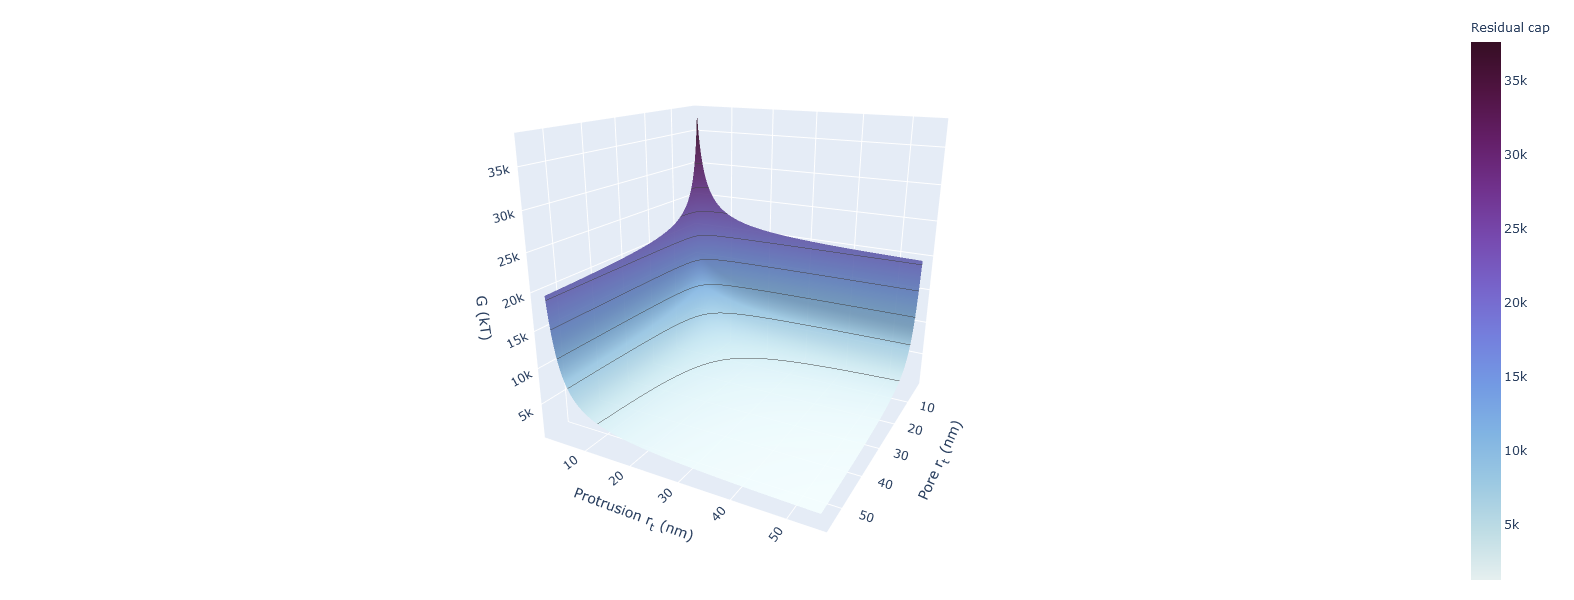

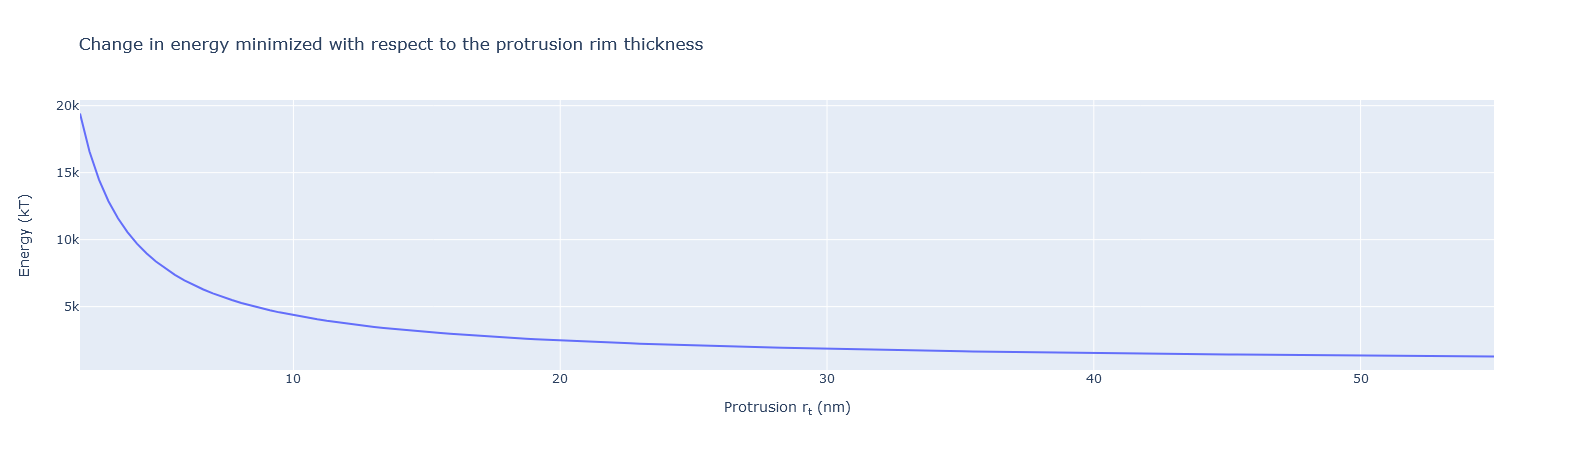

Saving DGb for base
Saving min path for base
Saving rim_rt for base
Saving plots as pdfs
Done!


In [8]:
#--------------------------------------------------------------------------------------------
# Calculate GPost - GPre and plot the surface
#--------------------------------------------------------------------------------------------
DGb = GPost - GPre

DGbPlot = go.Figure()
DGbPlot.add_trace(go.Surface(
    colorbar=go.surface.ColorBar(title='Residual cap'),
    colorscale='dense',
    contours={"z":{"show":True,"start":np.max(GPost)/10,"end":np.max(GPost)*0.9,
                   "size":np.max(GPost)/10}},
    name="Residual cap",
    x=rim_rt,y=rim_rt,z=DGb,opacity=0.9
))
DGbPlot.update_layout(coloraxis_showscale=False,
    scene = dict(
                    xaxis_title='Pore r<sub>t</sub> (nm)',
                    yaxis_title='Protrusion r<sub>t</sub> (nm)',
                    zaxis_title='G (kT)'),
    margin=dict(r=10, b=10, l=10, t=10),
    height=600,width=700)
view = dict(camera=dict(
    center=dict(x=0,y=-0.1,z=-0.1), #default is (0,0,0)
    eye=dict(x=2,y=1,z=0.75) #default is (1.25,1.25,1.25)
))
DGbPlot.update_layout(scene=view)
DGbPlot.show()

#--------------------------------------------------------------------------------------------
# Calculate the minimum path and plot it
#--------------------------------------------------------------------------------------------
# If we minimize DGb with respect to the pore's rt (so that the min path is a fxn of the 
# protrusion rt), we can see by simple inspection of the surface that the min path simply 
# follows where protrusion rt is at a max.  Therefore, the min path is simply that edge of 
# the surface
DGbMinPath = np.zeros(rim_rt.size)

for i in range(0,rim_rt.size):
    DGbMinPath[i] = DGb[rim_rt.size-1,i]

minPlot = go.Figure()
minPlot.add_trace(go.Scatter(x=rim_rt, y=DGbMinPath, mode='lines'))
minPlot.update_layout(title="Change in energy minimized with respect to the protrusion rim thickness",
                        xaxis_title="Protrusion r<sub>t</sub> (nm)", yaxis_title="Energy (kT)")
minPlot.show()

print('Saving DGb for base')
np.savetxt('output data/Base DGb 2-3.csv', DGb, delimiter=',') # Export DGb as a versioned csv
print('Saving min path for base')
np.savetxt('output data/Base min path 2-3.csv', DGbMinPath, delimiter=',') # Export as a versioned csv
print('Saving rim_rt for base')
np.savetxt('output data/Base rt 2-3.csv', rim_rt, delimiter=',') # Export rim_rt that was used
print('Saving plots as pdfs')
DGbPlot.write_image("output data/Base DGb 2-3.svg") #To save as vector img, must export manually
DGbPlot.write_image("output data/Base DGb 2-3.pdf") #SVG preferred, but Overleaf only works w PDF
minPlot.write_image("output data/Base DGb min path 2-3.pdf")
postGPlot.write_image("output data/Base post fusion rims 2-3.pdf")
print('Done!')